In [1]:
import torch
import pandas as pd
import numpy as np
from enformer_pytorch import from_pretrained
from scipy.stats import pearsonr
from enformer_pytorch import seq_indices_to_one_hot
import matplotlib.pyplot as plt
import seaborn as sns
#from enformer_pytorch.finetune import HeadAdapterWrapper

# Individual Prediction

In [2]:
df = pd.read_csv('./data_/chr22_expression.bed', sep='\t')

In [289]:
df['Gene_Symbol_2'] = df['gene_id'].str.split('.').apply(lambda x: x[0])
df

,#chr,start,end,gene_id,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZVE2,GTEX-ZVP2,GTEX-ZVT2,GTEX-ZVT3,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,Gene_Symbol_2
0,chr22,16601886,16601887,ENSG00000100181.22,1.570734,-0.770282,-1.353622,0.512862,-0.853391,-0.560321,...,-1.821345,2.214046,1.217151,-0.902828,0.376684,1.265581,-0.954578,0.001868,0.919804,ENSG00000100181
1,chr22,16612581,16612582,ENSG00000283633.1,1.747926,-0.996665,-0.582310,-1.545582,0.372677,0.231802,...,-1.040597,1.178870,1.114008,-0.534285,2.259617,1.079918,-0.133007,0.144322,1.209352,ENSG00000283633
2,chr22,16821698,16821699,ENSG00000172967.7,0.869633,-0.417104,-1.197791,0.735562,-0.254890,-1.197791,...,-0.392775,1.382185,0.740467,-1.197791,-0.293681,1.714493,-1.197791,-0.095404,0.061677,ENSG00000172967
3,chr22,17036569,17036570,ENSG00000237438.7,1.232973,-1.034199,-0.931270,-0.182182,-1.432461,0.595640,...,-1.073249,0.095404,-1.765402,0.573481,-1.498020,0.328973,-0.336870,0.227967,-0.340827,ENSG00000237438
4,chr22,17067820,17067821,ENSG00000273203.1,-0.696937,-0.750331,-0.069165,0.687444,-0.491673,-1.396898,...,0.099157,0.960486,0.348756,-1.396898,-0.243330,1.558035,-0.325032,-0.151876,0.569083,ENSG00000273203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,chr22,50601454,50601455,ENSG00000100288.19,0.212657,-1.382185,0.445806,0.659325,0.297584,-0.491673,...,1.442962,-0.604585,-1.027843,0.425269,-0.725805,1.282401,-0.035496,-0.842686,0.328973,ENSG00000100288
570,chr22,50628172,50628173,ENSG00000100299.17,0.309319,-0.035496,0.364680,-1.021528,-0.364680,0.805956,...,-0.487461,-1.027843,0.227967,-0.336870,-0.384717,1.273946,0.551601,0.730675,0.197397,ENSG00000100299
571,chr22,50674414,50674415,ENSG00000251322.7,-1.114008,-0.224134,-0.205021,-1.186387,0.364680,0.117946,...,0.720952,-0.937049,0.437569,-0.760269,1.086635,-0.795660,0.449935,0.009339,-1.034199,ENSG00000251322
572,chr22,50756947,50756948,ENSG00000184319.15,0.344789,-0.114185,-2.134683,0.500121,-2.749905,0.216479,...,-0.178385,0.336870,-1.241002,-1.021528,-0.479065,0.529981,1.335178,-0.024284,0.148098,ENSG00000184319


In [290]:
annotations = pd.read_csv('./data_/gene_annot.txt', sep='\t')
annotations = annotations[annotations['CHR'] == 22]
genomes = pd.read_csv('./data_/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt', sep='\t')
genomes = genomes[genomes['Chr'] == '22']
genomes['Gene_Symbol'] = genomes['Gene_Symbol'].str.split('.').apply(lambda x: x[0])
genomes = genomes.merge(annotations, left_on = 'Gene_Symbol', right_on='SYM')
genomes

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20816,NA20819,NA20826,NA20828,ID,CHR,START,STOP,SYM,TYPE
0,ENSG00000075240.12,ENSG00000075240,22,46971909,3.531803,3.635541,1.251434,3.007745,3.574070,4.569758,...,4.678466,4.626435,5.101994,4.100622,GRAMD4,22,46576011,46679791,ENSG00000075240,protein_coding
1,ENSG00000099937.6,ENSG00000099937,22,21128167,0.519054,0.399216,0.078965,0.145628,0.446993,0.217271,...,0.449070,0.081118,0.164197,0.287428,SERPIND1,22,20773878,20787720,ENSG00000099937,protein_coding
2,ENSG00000099998.12,ENSG00000099998,22,24641110,0.073630,0.041109,0.017493,-0.020552,0.000059,-0.007782,...,-0.008820,0.017421,0.010471,0.105646,GGT5,22,24219653,24245142,ENSG00000099998,protein_coding
3,ENSG00000093072.10,ENSG00000093072,22,17739125,13.346947,13.498284,2.517852,8.609994,15.017319,14.754466,...,18.068740,35.694934,8.627495,10.176125,CECR1,22,17179303,17221989,ENSG00000093072,protein_coding
4,ENSG00000185838.9,ENSG00000185838,22,19842462,2.333713,2.693720,3.923889,12.928828,5.288832,4.620438,...,12.989474,3.966684,6.080704,10.641336,GNB1L,22,19801998,19821375,ENSG00000185838,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,ENSG00000184117.7,ENSG00000184117,22,29977326,38.734821,45.964424,20.179679,38.704995,44.009728,49.872467,...,33.668940,39.979210,37.102068,30.871229,NIPSNAP1,22,29558869,29581337,ENSG00000184117,protein_coding
375,ENSG00000100121.8,ENSG00000100121,22,22988780,2.198850,2.083065,1.996587,2.239116,3.570457,4.731377,...,4.337316,3.922871,4.006087,1.814178,GGTLC2,22,22646345,22647741,ENSG00000100121,protein_coding
376,ENSG00000099958.10,ENSG00000099958,22,24181315,7.977406,9.358290,4.416089,7.388032,9.040660,3.006184,...,8.942371,11.637476,5.709065,5.991736,DERL3,22,23837646,23839012,ENSG00000099958,protein_coding
377,ENSG00000100335.8,ENSG00000100335,22,39895437,32.780167,19.257997,10.134445,19.492117,23.514977,18.573965,...,17.402229,15.723492,18.447801,22.720913,MIEF1,22,39499431,39518132,ENSG00000100335,protein_coding


In [291]:
merged = genomes.merge(df, left_on='Gene_Symbol', right_on='Gene_Symbol_2', how='right')[['Gene_Symbol','Gene_Symbol_2']]

In [12]:
ids = pd.read_csv('./data_/GTEx_v8_genotype_EUR_HM3_exclude_dups.allchr.reorder.fam', header=None, sep='\s+').iloc[:,1].tolist()

In [13]:
# Load VCF file (skip header lines starting with "#")
vcf_file = "./data_/genotype_sequences2.vcf"
vcf_df = pd.read_csv(vcf_file, comment="#", sep="\t", header=None)

# Define VCF column names
vcf_columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"] + ids
vcf_df.columns = vcf_columns

# Print first few rows
vcf_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,GTEX-111CU,...,GTEX-ZXES,GTEX-ZXG5,GTEX-ZYFD,GTEX-ZYFG,GTEX-ZYT6,GTEX-ZYVF,GTEX-ZYY3,GTEX-ZZ64,GTEX-ZZPT,GTEX-ZZPU
0,22,16390411,rs131538,G,A,.,.,PR,GT,0/0,...,0/0,0/1,0/0,0/0,0/0,0/0,0/0,0/0,0/1,0/0
1,22,16406147,rs7287144,A,G,.,.,PR,GT,0/0,...,0/0,0/0,0/1,0/0,0/0,0/1,0/0,0/0,0/0,1/1
2,22,16551808,rs5747620,T,C,.,.,PR,GT,0/1,...,0/0,0/0,0/1,1/1,0/1,0/1,0/0,0/1,0/0,1/1
3,22,16573137,rs17430900,G,A,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
4,22,16573830,rs9605903,T,C,.,.,PR,GT,0/0,...,0/0,0/1,0/1,0/0,0/1,0/0,0/1,0/0,1/1,0/1


In [14]:
def convert_genotype_to_allele(row, individual="GTEX-111YS"):
    """Convert genotype (0/0, 0/1, 1/1) into a nucleotide sequence."""
    genotype = row[individual]
    ref, alt = row["REF"], row["ALT"]
    
    if genotype == "0/0":
        return ref  # Homozygous reference
    elif genotype in ["0/1", "1/0"]:
        return alt  # Assume alternate allele for heterozygous
    elif genotype == "1/1":
        return alt  # Homozygous alternate
    else:
        return "N"  # Missing data

# Apply genotype conversion for one individual (modify for multiple individuals)
vcf_df["Allele"] = vcf_df.apply(lambda row: convert_genotype_to_allele(row, individual="GTEX-111YS"), axis=1)

# Print first few allele mappings
print(vcf_df[["CHROM", "POS", "REF", "ALT", "Allele"]].head())

   CHROM       POS REF ALT Allele
0     22  16390411   G   A      G
1     22  16406147   A   G      G
2     22  16551808   T   C      T
3     22  16573137   G   A      G
4     22  16573830   T   C      C


In [15]:
import pandas as pd
from pyfaidx import Fasta

# Load the genome reference (e.g., hg38.fa)
#genome = Fasta("./data_/chr22_dnaseq.fasta")  # Replace with your genome FASTA file

# Load gene expression data (with columns: chr, gene, start, end, ind1, ind2, ...)
df = pd.read_csv('./data_/chr22_expression.bed', sep='\t')

# Compute TSS based on gene strand
df["tss"] = df["start"]

# Define Enformer input window (±98kb)
df["start_enformer"] = df["tss"] - 98000
df["end_enformer"] = df["tss"] + 98000

# Ensure valid genomic coordinates (no negative values)
df["start_enformer"] = df["start_enformer"].clip(lower=0)

print(df.head())  # Verify correct start and end positions

    #chr     start       end             gene_id  GTEX-111YS  GTEX-1122O  \
0  chr22  16601886  16601887  ENSG00000100181.22    1.570734   -0.770282   
1  chr22  16612581  16612582   ENSG00000283633.1    1.747926   -0.996665   
2  chr22  16821698  16821699   ENSG00000172967.7    0.869633   -0.417104   
3  chr22  17036569  17036570   ENSG00000237438.7    1.232973   -1.034199   
4  chr22  17067820  17067821   ENSG00000273203.1   -0.696937   -0.750331   

   GTEX-1128S  GTEX-113IC  GTEX-113JC  GTEX-117XS  ...  GTEX-ZVT2  GTEX-ZVT3  \
0   -1.353622    0.512862   -0.853391   -0.560321  ...   1.217151  -0.902828   
1   -0.582310   -1.545582    0.372677    0.231802  ...   1.114008  -0.534285   
2   -1.197791    0.735562   -0.254890   -1.197791  ...   0.740467  -1.197791   
3   -0.931270   -0.182182   -1.432461    0.595640  ...  -1.765402   0.573481   
4   -0.069165    0.687444   -0.491673   -1.396898  ...   0.348756  -1.396898   

   GTEX-ZVT4  GTEX-ZVZP  GTEX-ZVZQ  GTEX-ZXES  GTEX-ZXG5      

In [16]:
from pyfaidx import Fasta

# Load the reference genome
fasta = Fasta("./data_/38.fa")  # Replace with the correct reference genome file

def get_sequence(chrom, start, end):
    """Fetch DNA sequence from the FASTA file, ensuring valid chromosome names."""
    try:
        return str(fasta['22'][start:end]) #str(fasta[chrom][start:end])
    except KeyError:
        return "N" * (end - start)  # If chromosome is not found, return Ns

def fix_sequence_length(seq, target_length=196608):
    """Ensure DNA sequence is exactly 196608 bp by padding or trimming."""
    seq = seq.upper()  # Ensure consistency
    if len(seq) < target_length:
        seq += "N" * (target_length - len(seq))  # Pad with 'N' if too short
    return seq[:target_length]  # Trim if too long

# Extract DNA sequences for each gene window
df["sequence"] = df.apply(lambda row: get_sequence(row["#chr"], row["start_enformer"], row["end_enformer"]), axis=1)
df["sequence"] = df["sequence"].apply(lambda seq: fix_sequence_length(seq))

# Print to verify extracted sequences
print(df[["#chr", "start_enformer", "end_enformer", "sequence"]].head())

    #chr  start_enformer  end_enformer  \
0  chr22        16503886      16699886   
1  chr22        16514581      16710581   
2  chr22        16723698      16919698   
3  chr22        16938569      17134569   
4  chr22        16969820      17165820   

                                            sequence  
0  AGCCATGTCCACTGCTCTTCATAGGTGGGGTGCATTCCAGCCATCT...  
1  GCACTCCAGCCTAGGTGACAGAGCAAGACTCCATCTCAAAAAAAAA...  
2  CTTCTTAGACTGTACCGTCCCCCATATTTCTCTTTGTCTATAGAAA...  
3  CAGCCTGGACCTATTGCAGAGCCTTCTCTTTTTCTGAACCCCAGTG...  
4  CGTGACTGTCCTAGGAATCTGGTGCACTGAGAGTGGGGTGGCCGGA...  


In [17]:
df.to_csv('./data_/sequences_gtex.csv', index=False)

In [125]:
q = vcf_df[['POS', 'Allele']]
q.to_csv('./data_/gtexvcf_q.csv')

In [126]:
#run apply variants in terminal

In [127]:
df = pd.read_csv('data_/modified_sequences_gtex.csv')
df

,#chr,start,end,gene_id,GTEX-111YS,GTEX-1122O,GTEX-1128S,GTEX-113IC,GTEX-113JC,GTEX-117XS,...,GTEX-ZVT4,GTEX-ZVZP,GTEX-ZVZQ,GTEX-ZXES,GTEX-ZXG5,tss,start_enformer,end_enformer,sequence,modified_seq
0,chr22,16601886,16601887,ENSG00000100181.22,1.570734,-0.770282,-1.353622,0.512862,-0.853391,-0.560321,...,0.376684,1.265581,-0.954578,0.001868,0.919804,16601886,16503886,16699886,AGCCATGTCCACTGCTCTTCATAGGTGGGGTGCATTCCAGCCATCT...,AGCCATGTCCACTGCTCTTCATAGGTGGGGTGCATTCCAGCCATCT...
1,chr22,16612581,16612582,ENSG00000283633.1,1.747926,-0.996665,-0.582310,-1.545582,0.372677,0.231802,...,2.259617,1.079918,-0.133007,0.144322,1.209352,16612581,16514581,16710581,GCACTCCAGCCTAGGTGACAGAGCAAGACTCCATCTCAAAAAAAAA...,GCACTCCAGCCTAGGTGACAGAGCAAGACTCCATCTCAAAAAAAAA...
2,chr22,16821698,16821699,ENSG00000172967.7,0.869633,-0.417104,-1.197791,0.735562,-0.254890,-1.197791,...,-0.293681,1.714493,-1.197791,-0.095404,0.061677,16821698,16723698,16919698,CTTCTTAGACTGTACCGTCCCCCATATTTCTCTTTGTCTATAGAAA...,CTTCTTAGACTGTACCGTCCCCCATATTTCTCTTTGTCTATAGAAA...
3,chr22,17036569,17036570,ENSG00000237438.7,1.232973,-1.034199,-0.931270,-0.182182,-1.432461,0.595640,...,-1.498020,0.328973,-0.336870,0.227967,-0.340827,17036569,16938569,17134569,CAGCCTGGACCTATTGCAGAGCCTTCTCTTTTTCTGAACCCCAGTG...,CAGCCTGGACCTATTGCAGAGCCTTCTCTTTTTCTGAACCCCAGTG...
4,chr22,17067820,17067821,ENSG00000273203.1,-0.696937,-0.750331,-0.069165,0.687444,-0.491673,-1.396898,...,-0.243330,1.558035,-0.325032,-0.151876,0.569083,17067820,16969820,17165820,CGTGACTGTCCTAGGAATCTGGTGCACTGAGAGTGGGGTGGCCGGA...,CGTGACTGTCCTAGGAATCTGGTGCACTGAGAGTGGGGTGGCCGGA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,chr22,50601454,50601455,ENSG00000100288.19,0.212657,-1.382185,0.445806,0.659325,0.297584,-0.491673,...,-0.725805,1.282401,-0.035496,-0.842686,0.328973,50601454,50503454,50699454,TCGGAGGCAGCTCCGGAGTCTTTCTGGGAGGCTGGCCTGCGCTTCT...,TCGGAGGCAGCTCCGGAGTCTTTCTGGGAGGCTGGCCTGCGCTTCT...
570,chr22,50628172,50628173,ENSG00000100299.17,0.309319,-0.035496,0.364680,-1.021528,-0.364680,0.805956,...,-0.384717,1.273946,0.551601,0.730675,0.197397,50628172,50530172,50726172,GGCCGTCGGCGGGGGTGATCCCTGGCCGGTCCCGCCCGGCGTGGGT...,GGCCGTCGGCGGGGGTGATCCCTGGCCGGTCCCGCCCGGCGTGGGT...
571,chr22,50674414,50674415,ENSG00000251322.7,-1.114008,-0.224134,-0.205021,-1.186387,0.364680,0.117946,...,1.086635,-0.795660,0.449935,0.009339,-1.034199,50674414,50576414,50772414,CTCACCCAGCCCCATTATTCTCAAGCCCTTAAGGCCACTCTTTGCA...,CTCACCCAGCCCCATTATTCTCAAGCCCTTAAGGCCACTCTTTGCA...
572,chr22,50756947,50756948,ENSG00000184319.15,0.344789,-0.114185,-2.134683,0.500121,-2.749905,0.216479,...,-0.479065,0.529981,1.335178,-0.024284,0.148098,50756947,50658947,50854947,GCTAGTCTCGAACTCCTGACCTCATGATCCGCCCAACTCGGCCTCC...,GCTAGTCTCGAACTCCTGACCTCATGATCCGCCCAACTCGGCCTCC...


In [128]:
import torch

def one_hot_encode(sequence):
    """Convert a DNA sequence into one-hot encoding (A, C, G, T)."""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4}
    seq_indices = [mapping.get(base, 4) for base in sequence]
    
    # Convert to one-hot encoding (5 channels: A, C, G, T, N)
    one_hot = torch.nn.functional.one_hot(torch.tensor(seq_indices), num_classes=5)
    
    return one_hot.float().T[:4]  # Shape: (4, sequence_length), removing "N" channel

# Apply one-hot encoding
df["one_hot"] = df["modified_seq"].apply(lambda seq: one_hot_encode(seq))

# Print shape to verify
print("One-hot encoded sequence shape:", df["one_hot"].iloc[0].shape)  # Should be (4, 196608)

One-hot encoded sequence shape: torch.Size([4, 196608])


In [129]:
from enformer_pytorch import from_pretrained

# Load pretrained Enformer
device = "cpu"
model = from_pretrained('EleutherAI/enformer-official-rough').to(device)
#output_file = "predictions.txt"

# Run Enformer on each sequence
with torch.no_grad():
    predictions = []
    predictions2 = []
    
    for i in range(len(df["one_hot"])):#for i in range(len(df["one_hot"])):
        if i % 25 == 0: 
            print(i)
        one_hot_seq = df["one_hot"].iloc[i]
        seq_input = one_hot_seq.unsqueeze(0).to(device)  # Add batch dimension
        seq_input = seq_input.permute(0, 2, 1)
        output = model(seq_input)  # Enformer output (chromatin accessibility, TF binding, etc.)
        result = output["human"].cpu().numpy()
        result1 = np.mean(result, axis=1)
        predictions.append(result1)  # Store human-specific prediction

        middle_bins = [447, 448, 449]
        result2 = np.sum(result[:, middle_bins,:], axis=1)
        predictions2.append(result2)

#df["enformer_output"] = predictions  # Store Enformer predictions

#print("Enformer output shape:", df["enformer_output"].iloc[0].shape)  # Should be (1, 896, 5313)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550


In [130]:
x = pd.DataFrame({'output': predictions})
x

,output
0,"[[0.084732756, 0.08851393, 0.108940616, 0.0903..."
1,"[[0.07963729, 0.08283099, 0.10222203, 0.080810..."
2,"[[0.037279338, 0.036558915, 0.028869985, 0.051..."
3,"[[0.10548426, 0.113033235, 0.14140968, 0.09478..."
4,"[[0.1867248, 0.1887269, 0.23705015, 0.1277424,..."
...,...
569,"[[0.3255753, 0.35369492, 0.48385313, 0.1832767..."
570,"[[0.28161162, 0.32356927, 0.44645664, 0.170438..."
571,"[[0.3040742, 0.35848945, 0.5329238, 0.16934098..."
572,"[[0.19087093, 0.21583483, 0.3561686, 0.0995956..."


In [4]:
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
exp_ids = df_targets[df_targets['description'].str.contains('CAGE')].index.tolist()
blood_ids = df_targets[(df_targets['description'].str.contains('blood')) & (df_targets['description'].str.contains('CAGE'))].index.tolist()

In [132]:
x['true'] = df['GTEX-117XS']
x['mean_prediction'] = x['output'].apply(lambda x: x[0].mean())
x['gene_exp_tracks'] = x['output'].apply(lambda x: np.mean(x[0][exp_ids]))

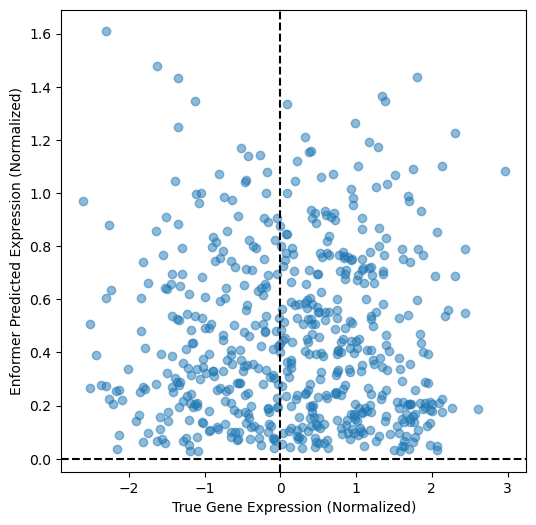

In [133]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(x["true"], x['gene_exp_tracks'].apply(np.mean), alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
plt.show()

In [134]:
from scipy.stats import pearsonr

corr, p_value = pearsonr(x['gene_exp_tracks'].apply(np.mean), x["true"])
corr

np.float64(-0.003141276390586034)

In [136]:
x.to_pickle('./data_/sum_stats_gtex117xs.pkl')

# One gene

In [2]:
f = pd.read_pickle('./data_/sum_stats_gene447.pkl')
f

,id,output,true,mean_prediction,gene_exp_tracks,blood_mean
0,GTEX-111YS,"[[0.16305864, 0.16405018, 0.1471794, 0.1427891...",-1.335178,1.400116,0.711904,0.585999
1,GTEX-1122O,"[[0.16311526, 0.16411506, 0.14720538, 0.142785...",-1.391960,1.399944,0.711846,0.586019
2,GTEX-1128S,"[[0.16300814, 0.16397445, 0.14724311, 0.142760...",-0.136777,1.397944,0.697863,0.575213
3,GTEX-113JC,"[[0.16300814, 0.16397445, 0.14724311, 0.142760...",-1.299592,1.397944,0.697863,0.575213
4,GTEX-117XS,"[[0.16311526, 0.16411506, 0.14720538, 0.142785...",1.073249,1.399944,0.711846,0.586019
...,...,...,...,...,...,...
569,GTEX-ZVT4,"[[0.16292255, 0.16394998, 0.14779815, 0.142348...",-0.140549,1.400173,0.708866,0.573078
570,GTEX-ZVZP,"[[0.16293928, 0.1640075, 0.14774908, 0.1423469...",-0.212657,1.402295,0.722701,0.583901
571,GTEX-ZVZQ,"[[0.16293928, 0.1640075, 0.14774908, 0.1423469...",1.282401,1.402295,0.722701,0.583901
572,GTEX-ZXES,"[[0.16298208, 0.1640323, 0.14716163, 0.1426878...",-1.217151,1.400111,0.712105,0.585968


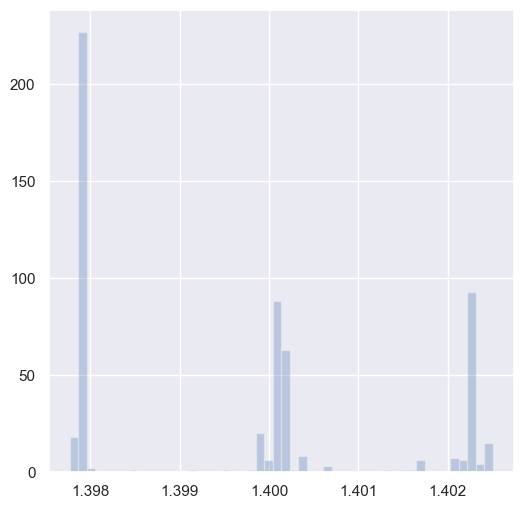

In [358]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.hist(f['mean_prediction'], bins=50, alpha=0.3)
plt.show()

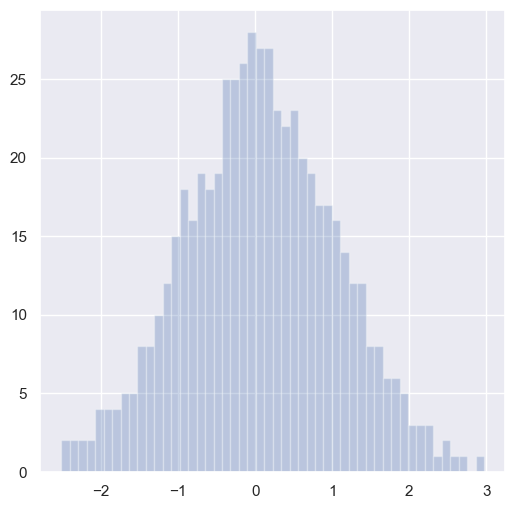

In [356]:
sns.set(font_scale=1)
plt.figure(figsize=(6,6))
plt.hist(f['true'], bins=50, alpha=0.3)
plt.show()

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
f["normalized_predictions"] = scaler.fit_transform(f["mean_prediction"].values.reshape(-1, 1))

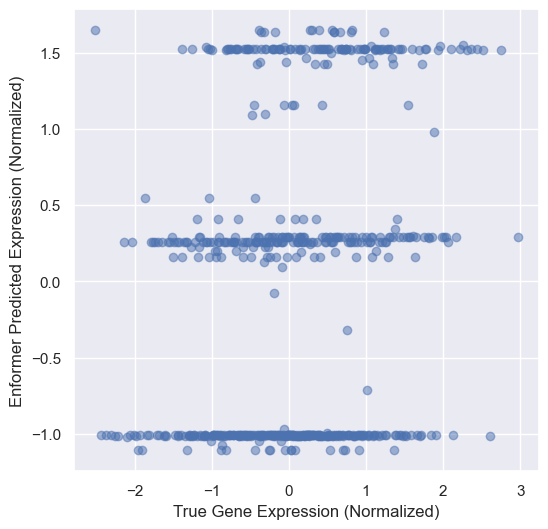

In [76]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(f['true'], f['normalized_predictions'], alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
# plt.axhline(0, color="black", linestyle="dashed")
# plt.axvline(0, color="black", linestyle="dashed")
#plt.savefig('./data_/mean_gtex.png')
plt.show()

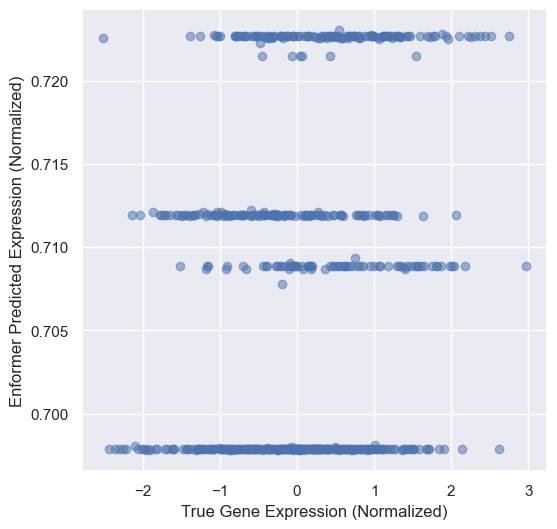

In [72]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(f['true'], f['gene_exp_tracks'], alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
# plt.axhline(0, color="black", linestyle="dashed")
# plt.axvline(0, color="black", linestyle="dashed")
#plt.savefig('./data_/mean_gtex.png')
plt.show()

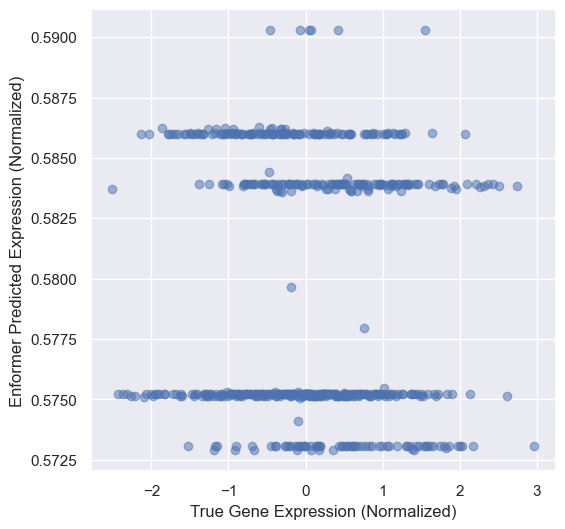

In [73]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(f['true'], f['blood_mean'], alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
# plt.axhline(0, color="black", linestyle="dashed")
# plt.axvline(0, color="black", linestyle="dashed")
#plt.savefig('./data_/mean_gtex.png')
plt.show()

In [5]:
f_copy = f.copy()
f_copy.set_index('id', inplace=True)
f_copy = f_copy[['true', 'mean_prediction', 'gene_exp_tracks', 'blood_mean']]

In [6]:
from scipy.stats import rankdata

def quantile_normalize_per_column(df):
    """Applies quantile normalization column-wise."""
    norm_df = df.copy()
    sorted_col = np.sort(df.values, axis=0)
    rank_mean = np.mean(sorted_col, axis=1)  # Compute mean of sorted values
    for col in df.columns:
        # sorted_col = np.sort(df[col])
        # rank_mean = np.mean(sorted_col)  # Compute mean of sorted values
        ranks = rankdata(df[col], method='average') - 1  # Get ranks (0-based)
        norm_df[col] = [rank_mean[int(rank)] for rank in ranks]  # Assign mean rank values
    return norm_df

def z_score_normalize_per_column(df):
    """Applies z-score normalization column-wise."""
    return df.apply(lambda col: (col - col.mean()) / col.std(), axis=0)

def log_transform_per_column(df):
    """Applies log transformation column-wise (log1p to handle zeros)."""
    return df.apply(lambda col: np.log1p(col- col.min() +1), axis=0)

In [7]:
def quantile_normalize(df):
    """Applies quantile normalization to a DataFrame."""
    sorted_df = np.sort(df, axis=0)  # Sort each column
    rank_mean = np.mean(sorted_df, axis=1)  # Compute mean across columns
    ranks = np.apply_along_axis(rankdata, 0, df) - 1  # Get ranks (0-based)
    norm_df = np.zeros_like(df)
    
    for i in range(df.shape[1]):
        norm_df[:, i] = rank_mean[ranks[:, i].astype(int)]  # Assign mean rank values
    
    return pd.DataFrame(norm_df, index=df.index, columns=df.columns)

In [8]:
# Apply normalization & transformation
quantile_norm_df = quantile_normalize(f_copy)
zscore_norm_df = z_score_normalize_per_column(f_copy)
log_transformed_df = log_transform_per_column(f_copy)
log_quantile = log_transform_per_column(quantile_norm_df)

# Display results
print("Quantile Normalized Expression:\n", quantile_norm_df.head())
print("Z-Score Normalized Expression:\n", zscore_norm_df.head())
print("Log-Transformed Expression:\n", log_transformed_df.head())

Quantile Normalized Expression:
                 true  mean_prediction  gene_exp_tracks  blood_mean
id                                                                
GTEX-111YS  0.333420         0.724204         0.795860    0.965110
GTEX-1122O  0.319225         0.657457         0.731870    1.098472
GTEX-1128S  0.633561         0.555271         0.549035    0.614591
GTEX-113JC  0.342317         0.555271         0.549035    0.614591
GTEX-117XS  0.946059         0.657457         0.731870    1.098472
Z-Score Normalized Expression:
                 true  mean_prediction  gene_exp_tracks  blood_mean
id                                                                
GTEX-111YS -1.425481         0.258137         0.400999    1.292279
GTEX-1122O -1.483258         0.158097         0.395186    1.295945
GTEX-1128S -0.206109        -1.004491        -1.019332   -0.767894
GTEX-113JC -1.389273        -1.004491        -1.019332   -0.767894
GTEX-117XS  1.025091         0.158097         0.395186    1.2959

In [9]:
corr, p_value = pearsonr(quantile_norm_df['mean_prediction'], quantile_norm_df["true"])
corr

np.float64(0.2213430892610939)

In [42]:
corr, p_value = pearsonr(zscore_norm_df['mean_prediction'], zscore_norm_df["true"])
corr

np.float64(0.21538704674893455)

In [43]:
corr, p_value = pearsonr(log_transformed_df['mean_prediction'], log_transformed_df["true"])
corr

np.float64(0.20893638216764132)

In [44]:
corr, p_value = pearsonr(log_quantile['mean_prediction'], log_quantile["true"])
corr

np.float64(0.20893638216764132)

## One gene: ML models

In [43]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = f[['normalized_predictions']]
y = f[['true']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# X_train = f[[]].values.T
# y_train = true[['b', 'c', 'd']].values.T

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Ridge()

In [78]:
preds = model.predict(X_test)
print("Adjusted Correlation:", pearsonr(preds, y_test.values.flatten()))

Adjusted Correlation: PearsonRResult(statistic=np.float64(0.29393506548153625), pvalue=np.float64(0.0014305841836079207))


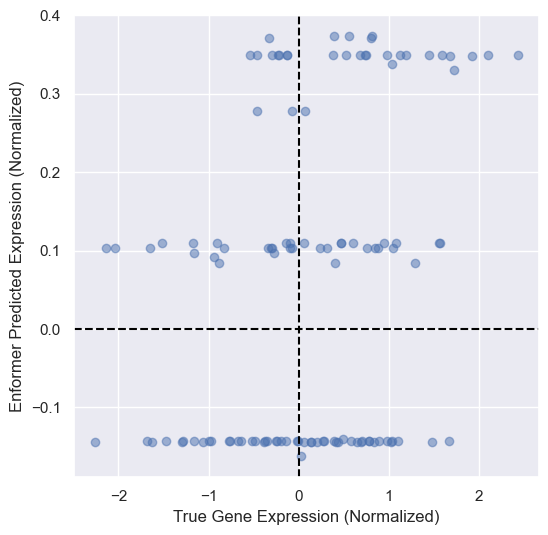

In [89]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(y_test.values.flatten(), preds, alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
#plt.savefig('./data_/mean_gtex.png')
plt.show()

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

/opt/anaconda3/envs/enformer/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


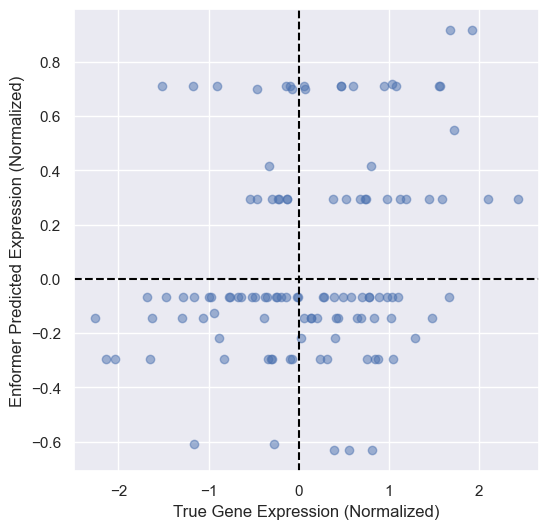

In [45]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(y_test.values.flatten(), rf_predicted, alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
#plt.savefig('./data_/mean_gtex.png')
plt.show()

In [46]:
print("Adjusted Correlation:", pearsonr(rf_predicted, y_test.values.flatten()))

Adjusted Correlation: PearsonRResult(statistic=np.float64(0.2604911625119318), pvalue=np.float64(0.004928777886948027))


In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
poly_adjusted_predictions = poly_model.predict(X_test)

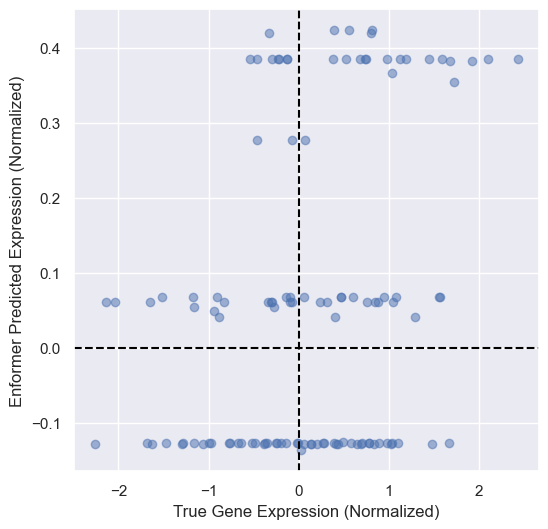

In [48]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(y_test.values.flatten(), poly_adjusted_predictions.flatten(), alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
#plt.savefig('./data_/mean_gtex.png')
plt.show()

In [49]:
print("Adjusted Correlation:", pearsonr(poly_adjusted_predictions.flatten(), y_test.values.flatten()))

Adjusted Correlation: PearsonRResult(statistic=np.float64(0.31769242169185585), pvalue=np.float64(0.000540707011856196))


In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
rf_adjusted_scaled = scaler.fit_transform(rf_predicted.reshape(-1, 1))

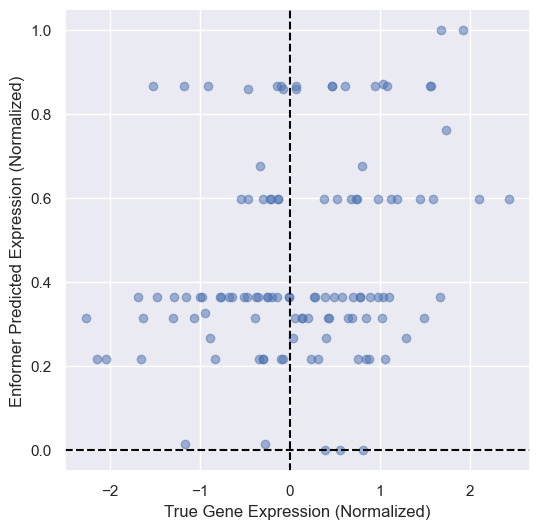

In [51]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(y_test.values.flatten(), rf_adjusted_scaled.flatten(), alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
#plt.savefig('./data_/mean_gtex.png')
plt.show()

In [52]:
print("Adjusted Correlation:", pearsonr(rf_adjusted_scaled.flatten(), y_test.values.flatten()))

Adjusted Correlation: PearsonRResult(statistic=np.float64(0.2604911625119318), pvalue=np.float64(0.004928777886948027))


# Multiple Indivividuals: Normalization

In [5]:
a = pd.read_pickle('./data_/sum_stats_gtex111ys')
a['blood'] = a['output'].apply(lambda x: np.mean(x[0][blood_ids]))

In [6]:
b = pd.read_pickle('./data_/sum_stats_gtex113jc')
# b['4950'] = b['output'].apply(lambda x: x[0][4950])

In [7]:
c = pd.read_pickle('./data_/sum_stats_gtex117xs.pkl')
# c['4950'] = c['output'].apply(lambda x: x[0][4950])

In [8]:
d = pd.read_pickle('./data_/sum_stats_gtexzvt4')
d['true'] = df['GTEX-ZVT4']
# d['4950'] = d['output'].apply(lambda x: x[0][4950])

In [9]:
e = pd.read_pickle('./data_/sum_stats_GTEX-18A7A.pkl')
e['gene_exp_tracks'] = e['gene_exp_tracks'].apply(lambda x: np.mean(x))
h = pd.read_pickle('./data_/sum_stats_gtex1r7ev.pkl')
m = pd.read_pickle('./data_/sum_stats_gtexrws6.pkl')
n = pd.read_pickle('./data_/sum_stats_gtexzvt2.pkl')

In [285]:
x = pd.read_pickle('./data_/sum_stats_HG00096')
y = pd.read_pickle('./data_/sum_stats_HG00102')
z = pd.read_pickle('./data_/sum_stats_NA20828')

In [292]:
x['id'] = genomes['Gene_Symbol']
y['id'] = genomes['Gene_Symbol']
z['id'] = genomes['Gene_Symbol']

In [293]:
x = x.merge(merged, left_on='id', right_on='Gene_Symbol_2', how='inner')
y= y.merge(merged, left_on='id', right_on='Gene_Symbol_2', how='inner')
z= z.merge(merged, left_on='id', right_on='Gene_Symbol_2', how='inner')

In [294]:
x = x.sort_values(by='id')
y = y.sort_values(by='id')
z = z.sort_values(by='id')

In [10]:
def expand_list_column(df, column_name):
    return df[column_name].apply(pd.Series)

def standardize_columns(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])
        mean = df[col].mean()
        std = df[col].std()
        df[col] = (df[col] - mean) / std
    return df

def expand_and_compute_mean(df):
    df['mean'] = expanded_df.mean(axis=1)  # Compute row-wise mean
    return df

In [11]:
for k in [a,b,c,d,e,h,m,n]:
    temp = pd.DataFrame({'blood':k['output'].apply(lambda x: x[0][blood_ids])})
    expanded_df = expand_list_column(temp, 'blood')
    j = standardize_columns(expanded_df, expanded_df.columns)
    p = expand_and_compute_mean(j)['mean']
    k['blood_mean'] = p

In [12]:
for i in ['4950', '4950_normal','mean_prediction', 'gene_exp_tracks', 'blood_mean']:
    g = pd.DataFrame()
    
    g["true_expression"] = np.log1p(a["indiv_one"] - a["indiv_one"].min() + 1)
    g["predicted_expression"] = np.log1p(a[i] - a[i].min() + 1)

# Normalize (Z-score)
    g["true_expression"] = (g["true_expression"] - g["true_expression"].mean()) / g["true_expression"].std()
    g["predicted_expression"] = (g["predicted_expression"] - g["predicted_expression"].mean()) / g["predicted_expression"].std()

    corr, p_value = pearsonr(g['predicted_expression'], g["true_expression"])
    print(f'{i}: {corr}')

4950: 0.032163252091333486
4950_normal: 0.03564549728633039
mean_prediction: 0.25161351228995277
gene_exp_tracks: 0.2578230348927905
blood_mean: 0.2139330934804812


In [13]:
b['blood'] = b['output'].apply(lambda x: x[0][blood_ids])
c['blood'] = c['output'].apply(lambda x: x[0][blood_ids])
d['blood'] = d['output'].apply(lambda x: x[0][blood_ids])
e['blood'] = e['output'].apply(lambda x: x[0][blood_ids])
h['blood'] = h['output'].apply(lambda x: x[0][blood_ids])
m['blood'] = m['output'].apply(lambda x: x[0][blood_ids])
n['blood'] = n['output'].apply(lambda x: x[0][blood_ids])

# x['blood'] = x['output'].apply(lambda x: x[0][blood_ids])
# y['blood'] = y['output'].apply(lambda x: x[0][blood_ids])
# z['blood'] = z['output'].apply(lambda x: x[0][blood_ids])

# x['gene_exp_tracks'] = x['output'].apply(lambda x: np.mean(x[0][exp_ids]))
# y['gene_exp_tracks'] = y['output'].apply(lambda x: np.mean(x[0][exp_ids]))
# z['gene_exp_tracks'] = z['output'].apply(lambda x: np.mean(x[0][exp_ids]))

In [14]:
for j in [b,c,d,e,h,m,n]:
    for i in ['mean_prediction', 'gene_exp_tracks','blood_mean']:
        g = pd.DataFrame()
    
        g["true_expression"] = np.log1p(j["true"] - j["true"].min() + 1)
        g["predicted_expression"] = np.log1p(j[i] - j[i].min() + 1)

# Normalize (Z-score)
        g["true_expression"] = (g["true_expression"] - g["true_expression"].mean()) / g["true_expression"].std()
        g["predicted_expression"] = (g["predicted_expression"] - g["predicted_expression"].mean()) / g["predicted_expression"].std()

        corr, p_value = pearsonr(g['predicted_expression'], g["true_expression"])
        print(f'{i}: {corr} \n')

mean_prediction: -0.11801557944841987 

gene_exp_tracks: -0.10392313260536751 

blood_mean: -0.06894943443619246 

mean_prediction: -0.036485007227281006 

gene_exp_tracks: -0.0015074921212404127 

blood_mean: -0.020676999710716997 

mean_prediction: 0.06635959425154067 

gene_exp_tracks: 0.05169206152230656 

blood_mean: 0.042157764632066524 

mean_prediction: 0.018394547393858332 

gene_exp_tracks: -0.03829684879056158 

blood_mean: -0.06136676259577872 

mean_prediction: -0.021440661208642787 

gene_exp_tracks: 0.04598551405931235 

blood_mean: 0.09076443200451728 

mean_prediction: 0.0867850066929566 

gene_exp_tracks: 0.06049882565022919 

blood_mean: 0.05450771594351609 

mean_prediction: 0.03642024913902589 

gene_exp_tracks: -0.027098361718984925 

blood_mean: -0.02472882723729893 



In [15]:
true = pd.DataFrame({'a': a['indiv_one'], 'b': b['true'], 'c': c['true'], 'd': d['true'], 'e':e['true'], 'h': h['true'], 'm':m['true'], 'n':n['true']})
predict_mean = pd.DataFrame({'mean_a': a['mean_prediction'], 'mean_b': b['mean_prediction'], 'mean_c': c['mean_prediction'],\
                             'mean_d': d['mean_prediction'], 'mean_e': e['mean_prediction'], 'mean_h': h['mean_prediction'], \
                            'mean_m': m['mean_prediction'], 'mean_n': n['mean_prediction']})

In [343]:
true['id_gtex'] = merged['Gene_Symbol_2']
true['id_1k'] = merged['Gene_Symbol']
true = true.dropna()

In [16]:
predict_gene = pd.DataFrame({'gene_exp_a': a['gene_exp_tracks'],'gene_exp_b': b['gene_exp_tracks'], 'gene_exp_c': c['gene_exp_tracks'], \
                             'gene_exp_d': d['gene_exp_tracks'], 'gene_exp_e': e['gene_exp_tracks'], 'gene_exp_h': h['gene_exp_tracks'], \
                            'gene_exp_m': m['gene_exp_tracks'], 'gene_exp_n': n['gene_exp_tracks']})
predict_blood = pd.DataFrame({'blood_a': a['blood_mean'], 'blood_b': b['blood_mean'], 'blood_c': c['blood_mean'], \
                              'blood_d': d['blood_mean'], 'blood_e': e['blood_mean'], 'blood_h': h['blood_mean'], \
                             'blood_m': m['blood_mean'], 'blood_n': n['blood_mean']})

In [346]:
predict_mean['id_gtex'] = merged['Gene_Symbol_2']
predict_mean['id_1k'] = merged['Gene_Symbol']
predict_mean = predict_mean.dropna()

predict_gene['id_gtex'] = merged['Gene_Symbol_2']
predict_gene['id_1k'] = merged['Gene_Symbol']
predict_gene = predict_gene.dropna()

predict_blood['id_gtex'] = merged['Gene_Symbol_2']
predict_blood['id_1k'] = merged['Gene_Symbol']
predict_blood = predict_blood.dropna()


predict_mean = predict_mean.sort_values(by='id_gtex')
predict_gene = predict_gene.sort_values(by='id_gtex')
predict_blood = predict_blood.sort_values(by='id_gtex')
true = true.sort_values(by='id_gtex')

In [358]:
predict_mean.reset_index(inplace=True, drop=True)
predict_gene.reset_index(inplace=True, drop=True)
predict_blood.reset_index(inplace=True, drop=True)
true.reset_index(inplace=True)

In [301]:
predict_mean['mean_x'] = x['mean_prediction']
predict_mean['mean_y'] = y['mean_prediction']
predict_mean['mean_z'] = z['mean_prediction']

predict_gene['gene_exp_x'] = x['gene_exp_tracks']
predict_gene['gene_exp_y'] = y['gene_exp_tracks']
predict_gene['gene_exp_z'] = z['gene_exp_tracks']

predict_blood['blood_x'] = x['blood_mean']
predict_blood['blood_y'] = y['blood_mean']
predict_blood['blood_z'] = z['blood_mean']

true['x'] = x['true']
true['y'] = y['true']
true['z'] = z['true']

## Multiple Individuals: ML models

In [98]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = predict_blood[['blood_b', 'blood_c', 'blood_d']].values.T
y_train = true[['b', 'c', 'd']].values.T

# X_train = predict_blood[['blood_b', 'blood_c', 'blood_d']].values.T
# y_train = true[['b', 'c', 'd']].values.T

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Ridge()

In [99]:
X_test = predict_blood[['blood_a']].values.T
y_test = true[['a']].values.T

preds = model.predict(X_test)
print("Adjusted Correlation:", pearsonr(preds[0], y_test[0]))

Adjusted Correlation: PearsonRResult(statistic=np.float64(-0.3923603581937056), pvalue=np.float64(1.4489718801032657e-22))


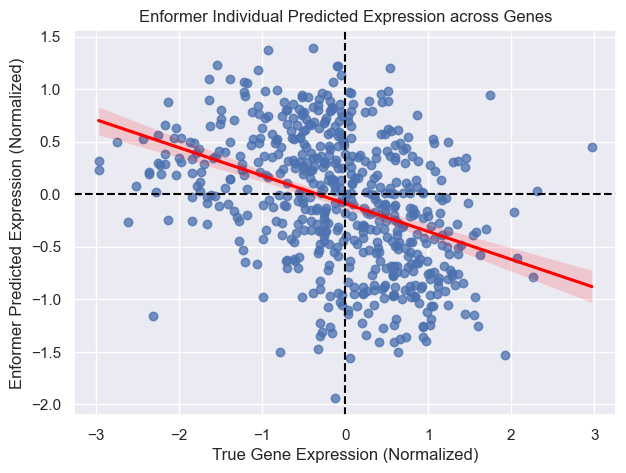

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1)
plt.figure(figsize=(7,5))
plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
plt.title(f"Enformer Individual Predicted Expression across Genes")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
sns.regplot(x=y_test, y=preds, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
plt.savefig('./data_/blood_gtex_2.png')
plt.show()

In [96]:
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

In [97]:
print("Adjusted Correlation:", pearsonr(rf_predicted[0], y_test[0]))

Adjusted Correlation: PearsonRResult(statistic=np.float64(-0.34587484727828677), pvalue=np.float64(1.422568320860669e-17))


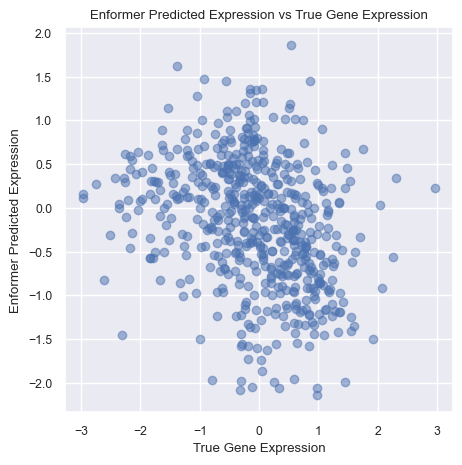

In [83]:
sns.set(font_scale=0.8)
plt.figure(figsize=(5, 5))
plt.scatter(y_test, rf_predicted, alpha=0.5)
plt.xlabel("True Gene Expression")
plt.ylabel("Enformer Predicted Expression")
plt.title(f"Enformer Predicted Expression vs True Gene Expression")
# plt.xlim(-10,600)
# plt.ylim(-10,600)
#plt.plot(x, y, color='red', linewidth=2)
#plt.plot(X_test, y_test, color='red', linewidth=2, label='Ridge Regression Line')
#sns.regplot(x=y_test, y=rf_predicted, order=0.9, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
# plt.axhline(0, color="black", linestyle="dashed")
# plt.axvline(0, color="black", linestyle="dashed")
# plt.savefig('./data_/blood_1000g.png', bbox_inches='tight')
plt.show()

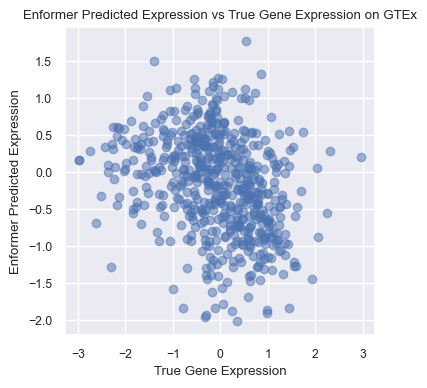

In [348]:
sns.set(font_scale=0.8)
plt.figure(figsize=(4, 4))
plt.scatter(y_test, rf_predicted, alpha=0.5)
plt.xlabel("True Gene Expression")
plt.ylabel("Enformer Predicted Expression")
plt.title(f"Enformer Predicted Expression vs True Gene Expression on GTEx")
#plt.plot(x, y, color='red', linewidth=2)
#plt.plot(X_test, y_test, color='red', linewidth=2, label='Ridge Regression Line')
#sns.regplot(x=y_test, y=rf_predicted, order=0.9, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})
# plt.axhline(0, color="black", linestyle="dashed")
# plt.axvline(0, color="black", linestyle="dashed")
plt.savefig('./data_/blood_gtex2.png', bbox_inches='tight')
plt.show()

In [281]:
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
poly_adjusted_predictions = poly_model.predict(X_test)

In [187]:
print("Adjusted Correlation:", pearsonr(poly_adjusted_predictions[0], y_test[0]))

Adjusted Correlation: PearsonRResult(statistic=np.float64(-0.24989420527279427), pvalue=np.float64(1.2746400367720532e-09))


In [188]:
scaler = MinMaxScaler()
rf_adjusted_scaled = scaler.fit_transform(rf_predicted.reshape(-1, 1))

In [189]:
print("Adjusted Correlation:", pearsonr(rf_adjusted_scaled.flatten(), y_test[0]))

Adjusted Correlation: PearsonRResult(statistic=np.float64(-0.2923475098065744), pvalue=np.float64(8.962230432125582e-13))


In [164]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = predict_gene[['gene_exp_a','gene_exp_c', 'gene_exp_d', 'gene_exp_e', 'gene_exp_h', 'gene_exp_m', 'gene_exp_n']].values.T
y_train = true[['a', 'c', 'd', 'e', 'h', 'm', 'n']].values.T

X_test = predict_gene[['gene_exp_b']].values.T
y_test = true[['b']].values.T

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("Adjusted Correlation:", pearsonr(preds[0], y_test[0]))

Adjusted Correlation: PearsonRResult(statistic=np.float64(0.001684944617003704), pvalue=np.float64(0.9678695526688375))


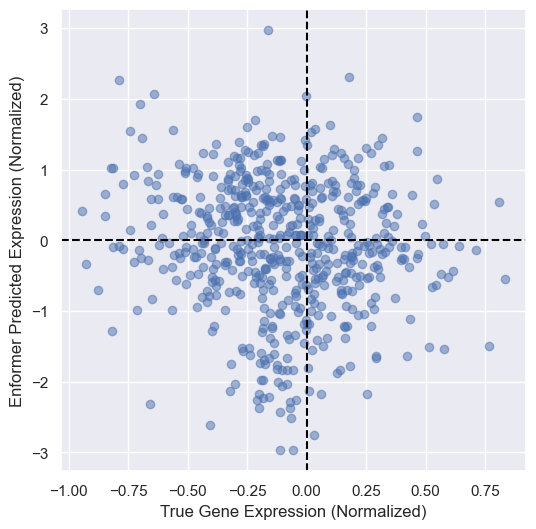

In [162]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(preds, y_test, alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
plt.savefig('./data_/gene_gtex.png')
plt.show()

In [385]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = predict_mean[['mean_b', 'mean_c', 'mean_d']].values.T
y_train = true[['b', 'c', 'd']].values.T

X_test = predict_mean[['mean_a']].values.T
y_test = true[['a']].values.T

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("Adjusted Correlation:", pearsonr(preds[0], y_test[0]))

Adjusted Correlation: PearsonRResult(statistic=np.float64(-0.393711208939633), pvalue=np.float64(2.3757853990198974e-14))


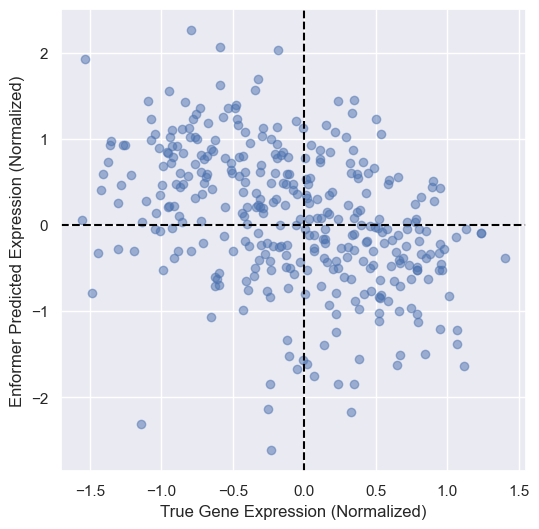

In [390]:
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plt.scatter(preds, y_test, alpha=0.5)
plt.xlabel("True Gene Expression (Normalized)")
plt.ylabel("Enformer Predicted Expression (Normalized)")
#plt.title(f"Enformer vs. True Gene Expression (r={corr:.2f})")
plt.axhline(0, color="black", linestyle="dashed")
plt.axvline(0, color="black", linestyle="dashed")
plt.savefig('./data_/mean_gtex.png')
plt.show()